In [102]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import neurospyke as ns
import h5py
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


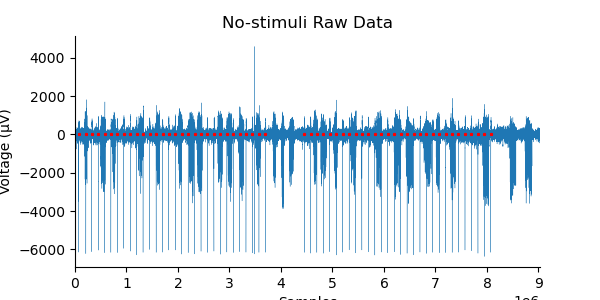

In [103]:
sampling_frequency = 25000 # 25 kHz
sampling_time = 1/sampling_frequency
f = h5py.File('./data/ET1/R21-15/PostLesion_Mapping/Raw_P1_Ch_001.mat')

data = f['data'][:]
data = np.reshape(data, np.size(data))

# ns.visualization.plot_raw_data(data, sampling_time = sampling_time)

stimulus_idxs, _ = find_peaks(data, height=2000, distance=4 * sampling_frequency)
# ns.visualization.plot_spikes(data, stimulus_idxs, title='Stimuli')

stimulus_duration = 40 # samples
stimulus_half_duration = int(np.ceil(stimulus_duration / 2))
stimulus_range = np.arange(-stimulus_half_duration, stimulus_half_duration)

transient_duration = 0.7 # seconds
transient_samples = int(np.ceil(transient_duration * sampling_frequency))
transient_range = np.arange(stimulus_half_duration, stimulus_half_duration + transient_samples)
transients = []

for stimulus_idx in stimulus_idxs:
    data[stimulus_idx + stimulus_range] = 0
    transients.append(data[stimulus_idx + transient_range])

ns.visualization.plot_spikes(data, stimulus_idxs, title='No-stimuli Raw Data')

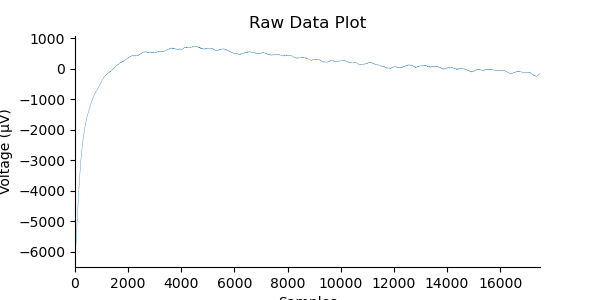

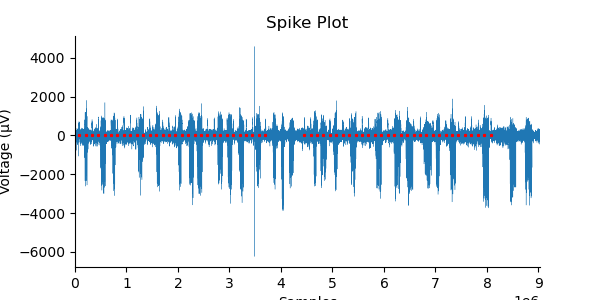

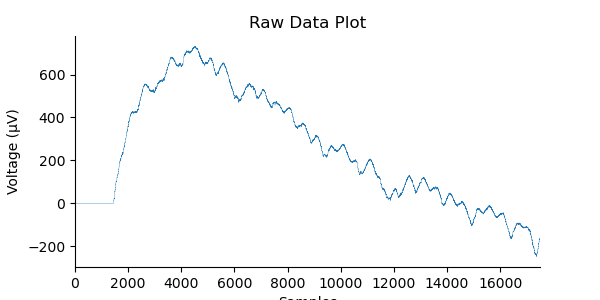

In [104]:

mean_transient = np.mean(transients, 0)
ns.visualization.plot_raw_data(mean_transient)
zero_idx = np.where(mean_transient >= 0)[0][0]
transients = []

for stimulus_idx in stimulus_idxs:
    data[np.arange(stimulus_idx + stimulus_half_duration, stimulus_idx + stimulus_half_duration + zero_idx)] = 0
    transients.append(data[stimulus_idx + transient_range])

ns.visualization.plot_spikes(data, stimulus_idxs)

mean_transient = np.mean(transients, 0)
ns.visualization.plot_raw_data(mean_transient)

AxesSubplot(0.125,0.11;0.352273x0.77)


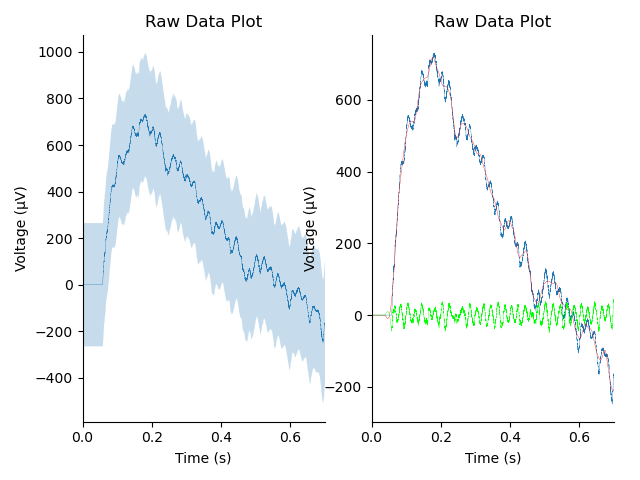

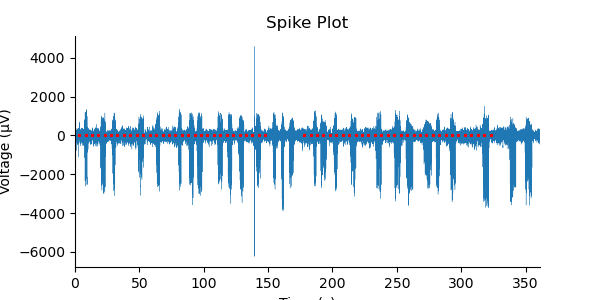

In [105]:
mean_transient_smoothed = savgol_filter(mean_transient, 1001, 3)

_, ax = plt.subplots(1, 2)
print(ax[0])
transient_std = np.std(mean_transient, 0)
ax[0].fill_between(transient_range * sampling_time, mean_transient - transient_std, mean_transient + transient_std, alpha=0.25)
ns.visualization.plot_raw_data(mean_transient, ax=ax[0], sampling_time=sampling_time)
plt.tight_layout()

ns.visualization.plot_raw_data(mean_transient, ax=ax[1], sampling_time=sampling_time)
ns.visualization.plot_raw_data(mean_transient_smoothed, ax=ax[1], sampling_time=sampling_time, color='#FF0000')
ns.visualization.plot_raw_data(mean_transient - mean_transient_smoothed, ax=ax[1], sampling_time=sampling_time, color='#00FF00')

for stimulus_idx in stimulus_idxs:
    data[stimulus_idx + transient_range] = data[stimulus_idx + transient_range] - mean_transient_smoothed

ns.visualization.plot_spikes(data, stimulus_idxs, sampling_time=sampling_time)